## Reference Model

In [1]:
import py0
import maxent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.30124777, 0.40674644, 0.13144951, 0.16055628],
        [0.31668048, 0.41174088, 0.16496866, 0.10660998],
        [0.19445892, 0.04088046, 0.32680835, 0.43785227],
        [0.2963057 , 0.21305113, 0.30436987, 0.18627329]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 0)
tmat.add_transition('A', 'I', 3, 0)
tmat.add_transition('I', 'R', 14, 0)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [5]:
infect = py0.contact_infection_func(infections_compartments)
model = py0.MetaModel(infect, 250)

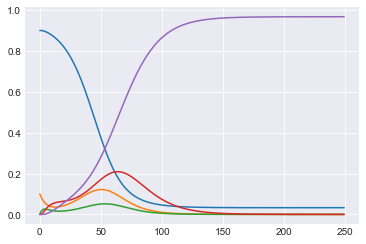

In [6]:
beta = np.array([0.02, 0.02])
ref_traj = model(R, tmat.value, start, beta)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [8]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 6, 3)
tmat.add_transition('I', 'R', 10, 4)

In [9]:
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.005]*2
hyper_pram.beta_high = [0.05]*2
hyper_pram.beta_var = [0.1]*2
param_model = py0.MetaParameterJoint(np.zeros((M,)), R * 0.9, tmat, name='unbiased_model', n_infectious_compartments=1, hypers = hyper_pram)

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


In [10]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
total_batches = N * batches
time = 250
outs = []
infect = py0.contact_infection_func(infections_compartments)
model = py0.MetaModel(infect, time)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:53<00:00,  3.34s/it]

(8192, 250, 4, 4)


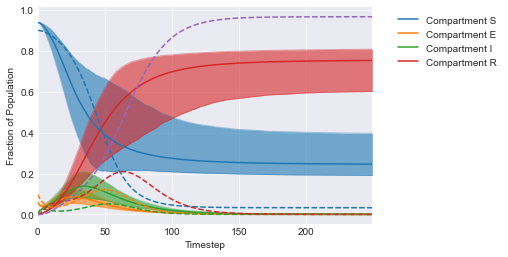

In [11]:
full_compartments = ['S'] + compartments
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [12]:
npoints = 5
prior = maxent.Laplace(0.1)
# prior = maxent.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = py0.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.02)

87 0.7701492 0.765529826129614
66 0.5056535 0.5117804035006066
73 0.60652626 0.6064332744963297
17 0.044827152 0.044755978050452574
52 0.30661172 0.3116606255831806


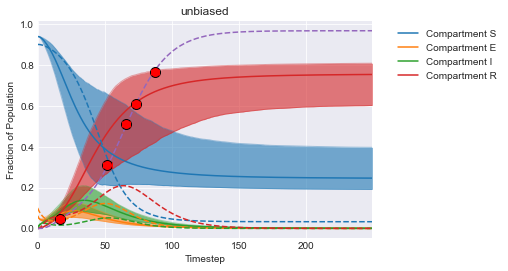

In [13]:
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [14]:
me_model = maxent.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [15]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [16]:
history = me_model.fit(trajs, batch_size=total_batches,epochs=100, callbacks=[CustomCallback()])

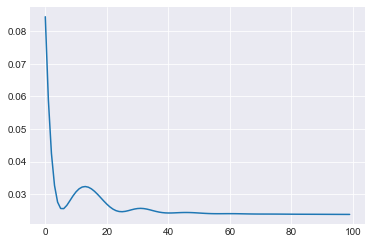

In [17]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [18]:
fit_param_model = py0.MetaParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model', n_infectious_compartments=1)
fit_param_model.compile(tf.optimizers.Adam(0.01))
# fit_param_model.compile(tf.optimizers.SGD(0.1))
hme_model = maxent.HyperMaxentModel(restraints, fit_param_model, model)
# hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3), 'mean_squared_error')                                                                          

In [19]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=3, batch_size=N*batches, epochs=16)

Epoch 1/16
16/16 [==============================] - 8s 2ms/step - loss: -0.1210 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1072
Epoch 2/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1210 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1072
Epoch 3/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1211 - R-dist-dist_loss: -0.0058 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1072
Epoch 4/16
16/16 [==============================] - 0s 2ms/step - loss: -0.1211 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1072
Epoch 5/16
16/16 [==============================] - 0s 3ms/step - loss: -0.1211 - R-dist-dist_loss: -0.0057 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0028 - beta-dist_loss: -0.1072
Epoch 6/16
16/16 [======================

In [20]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

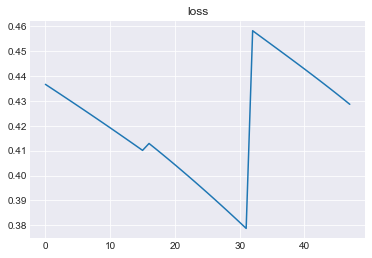

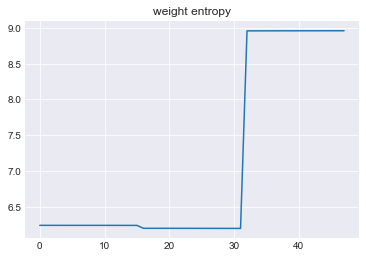

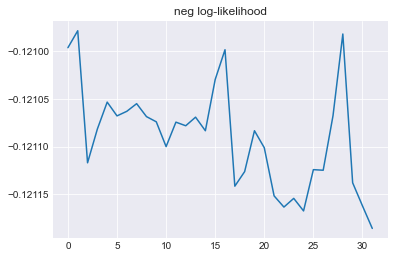

In [21]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [22]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.33736]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [23]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 R-dist-hypers (TrainableInputL  (None, 2, 4, 4)     32          ['input_2[0][0]']                
 ayer)                                                                                            
                                                                                                  
 R-dist-jitter (Lambda)         (None, 2, 4, 4)      0           ['R-dist-hypers[0][0]']          
                                                                                                  
 T-dist-hypers (TrainableInputL  (None, 2, 3, 3)     18          ['input_2[0][0

In [24]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([-0.19282746, -0.10052846,  0.05372862,  0.2051487 ], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [25]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[0.17207278 0.5192194  0.3757532  0.9289689  0.9111381 ] [-0.20055732  0.02473967 -0.06694291 -0.06088682  0.26549786]
0.42670885 0.023902591


In [26]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.979343 after tuning 8.962275


## Direct Regression of Model

In [62]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = py0.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += (r(traj[0])**2)[tf.newaxis]
    return s
rmodel = py0.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [63]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

tf.Tensor(0.26662868, shape=(), dtype=float32)
tf.Tensor(0.664895, shape=(), dtype=float32)
tf.Tensor(0.49777228, shape=(), dtype=float32)
tf.Tensor(2.31531, shape=(), dtype=float32)
tf.Tensor(1.1444011, shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_2:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_4:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_6:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_8:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_2:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_4:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_6:0", shape=(), dtype=float32)
Tensor("trainable_meta_model_16/lambda_16/sub_8:0", shape=(), dtype=float32)
100/1

## Now visualize results

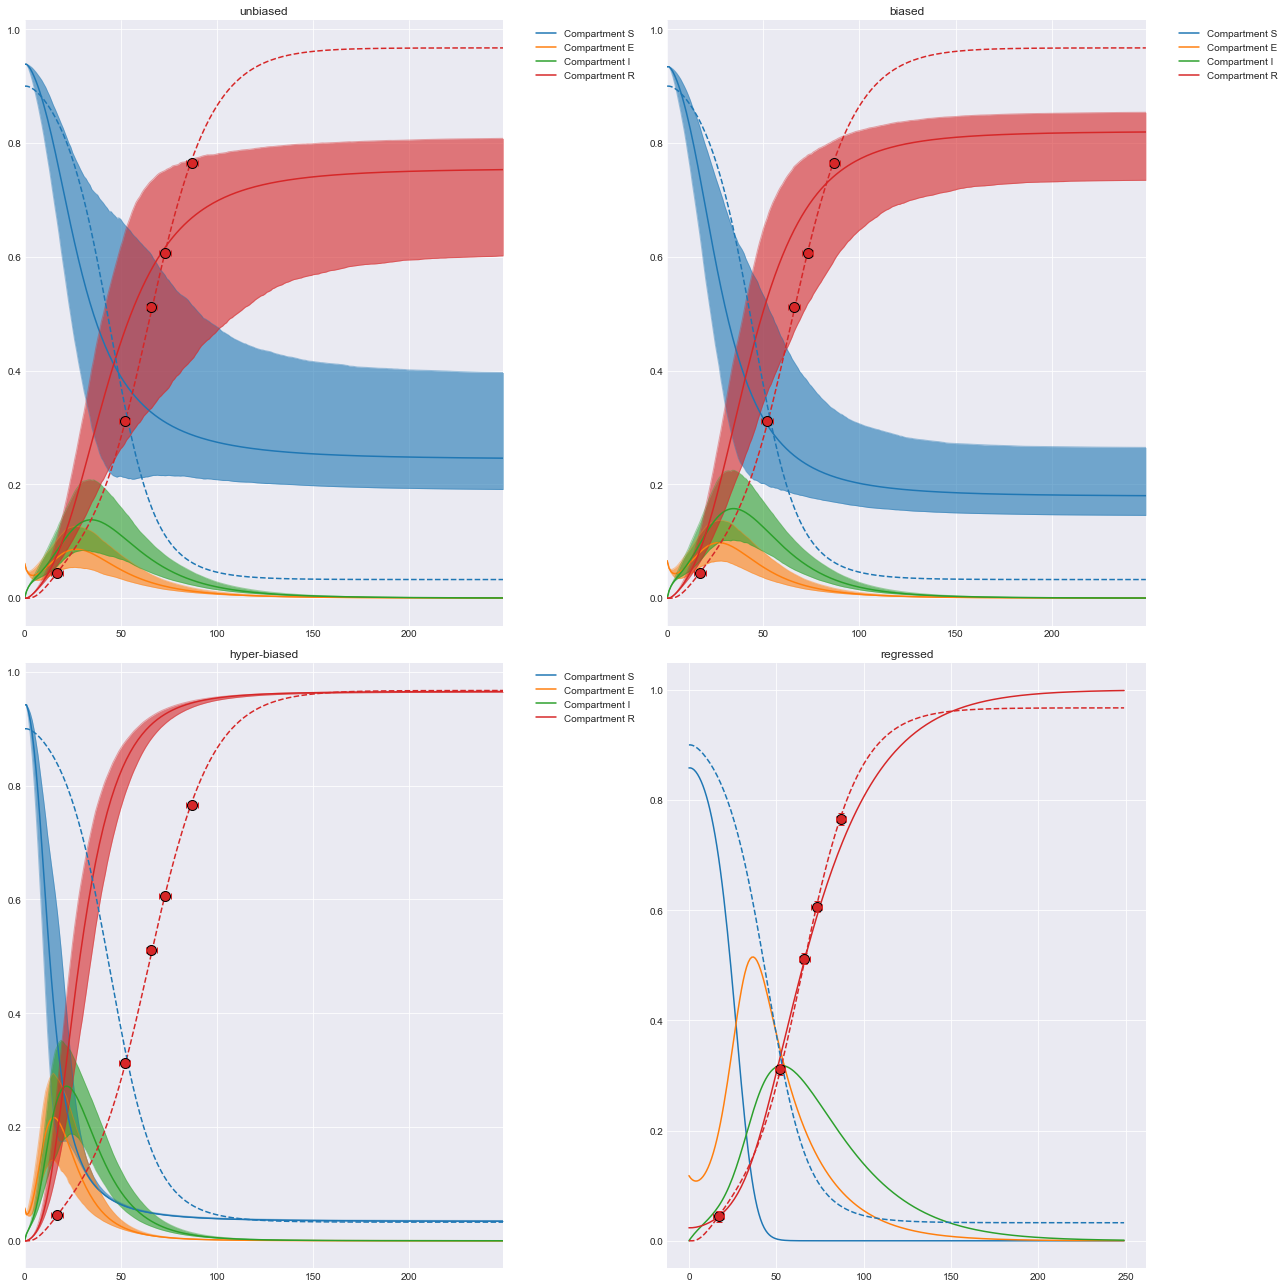

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
py0.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')

axs[0,1].set_title('biased')
py0.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
py0.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')


## Other Patch

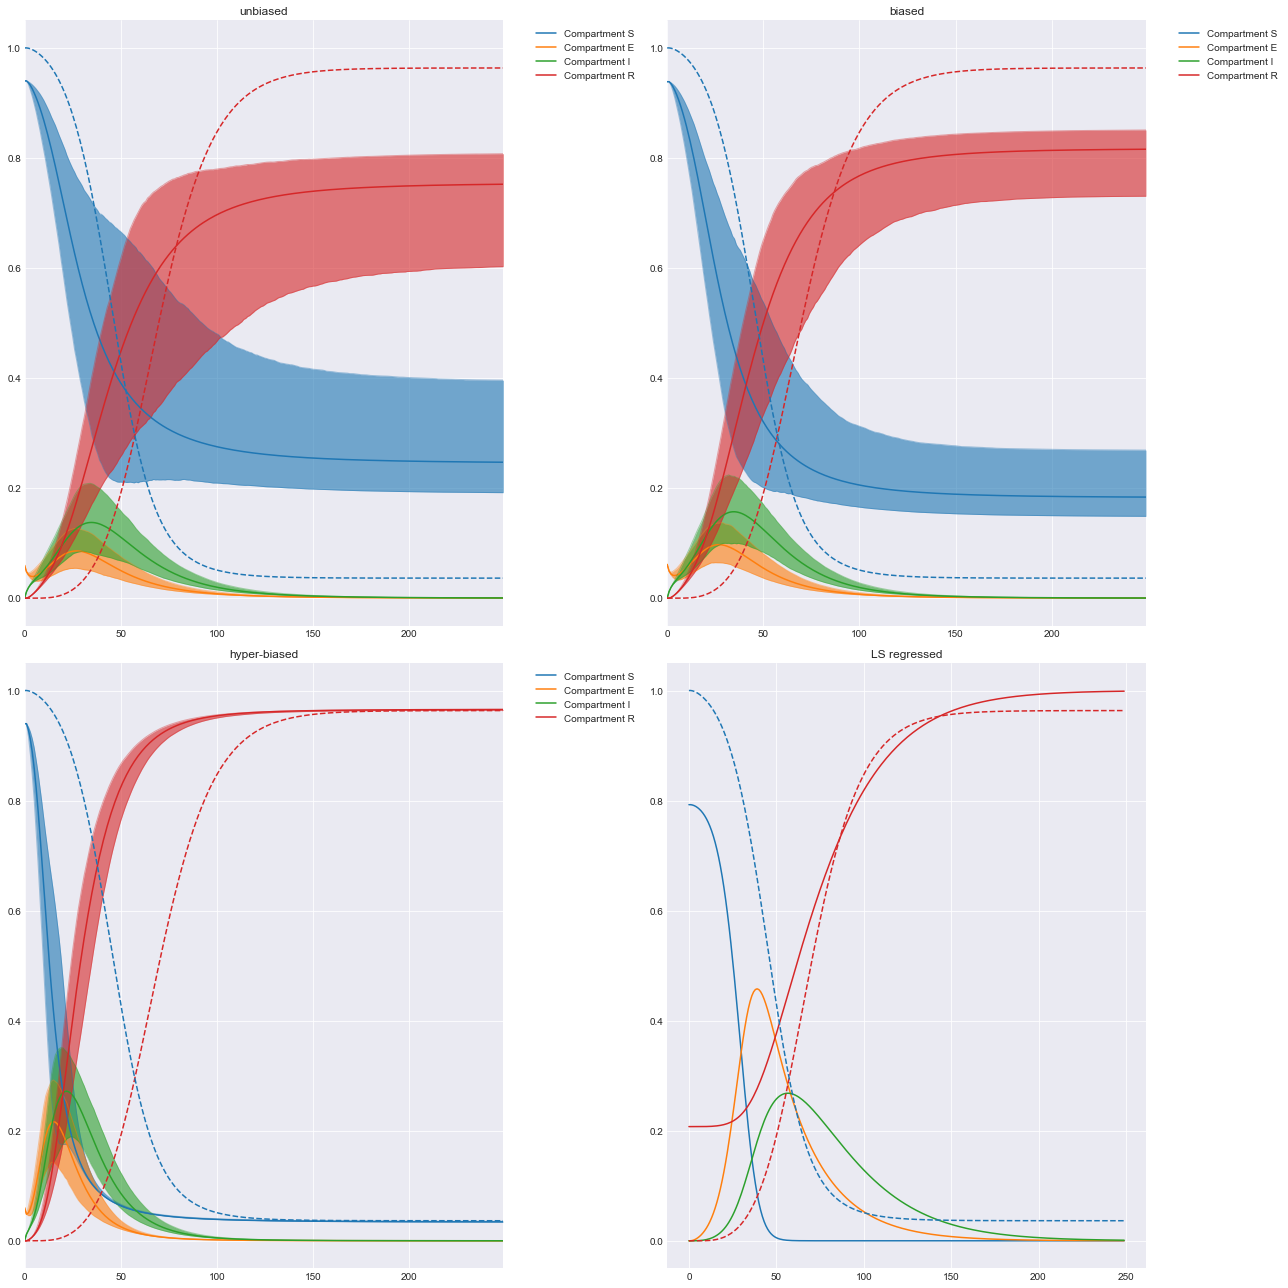

In [67]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
py0.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
py0.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
py0.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('LS regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()